# Homework 3
## Due Date:  Thursday, October 4th at 11:59 PM
### There are 3 parts to this homework.
   [Problem 1](#p1) Writing a Linear regression class using Object Oriented Programming (OOP) paradigm [40pts]<br>
   [Problem 2](#p2) Toy module [10pts] <br>
   [Problem 3](#p3) Writing Bank Account software using Object Oriented Programming (OOP) paradigm [50pts]
    
---

<a id='p1'></a>
## Problem 1:  Linear Regression Class [40pts]

In this problem, you will create custom `Python` classes for two related types of linear regression: Ordinary Least Squares Linear Regression and Ridge Regression.

You are prohibited from using standard regression libraries in `Python` such as `sklearn`.  These classes must be your own.  However, you *are* permitted to check your answers against standard libraries.

### Background

Consider the multivariate linear model:
$$y = X\beta + \epsilon$$
where $y$ is a length $n$ vector, $X$ is an $m \times p$ matrix, and $\beta$ is a $p$ length vector of coefficients.

The goal is to find the coefficients $\beta$ so that the linear model fits the data the best.  There are many approaches to this, but in this problem you will only consider two.

#### Ordinary Least Squares Linear Regression

[OLS Regression](https://en.wikipedia.org/wiki/Ordinary_least_squares) seeks to minimize the following cost function:

$$\|y - \beta X\|^{2}.$$

The best fit coefficients are given by:

$$\widehat{\beta} = (X^T X)^{-1}X^Ty$$

where $X^T$ is the transpose of the matrix $X$ and $X^{-1}$ is the inverse of the matrix $X$.

#### Ridge Regression

[Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) introduces an $L_{2}$ regularization so the new cost function is:

$$\|y - \beta X\|^{2}+\|\Gamma \beta \|^{2}.$$

where $\Gamma = \alpha I$ for some constant $\alpha$ and $I$ is the identity matrix.

The best fit coefficients for this case are given by:
$$\hat{\beta} = (X^T X+\Gamma^T\Gamma)^{-1}X^Ty.$$

#### $R^2$ score
You will use the [$R^{2}$ metric](https://en.wikipedia.org/wiki/Coefficient_of_determination) to assess the performance of the models.  The $R^2$ score is defined as:
$$\displaystyle R^{2} = 1-\dfrac{SS_{E}}{SS_{T}}$$
where
$$SS_{T}=\sum_{i}{\left(y_{i}-\overline{y}\right)^2}$$ and $$SS_{E}=\sum_{i}{\left(y_{i} - \widehat{y_i}\right)^2}.$$

The ${y_i}$ are the original data values, $\widehat{y_i}$ are the predicted values, and $\overline{y_i}$ is the mean of the original data values.

### Part 1:  Base Class
Write a class called `Regression` with the following methods:

`__init__()`: Initializez an empty dictionary called `params`.

`fit(X, y)`: Fits linear model to $X$ and $y$.  Stores best-fit parameters in the dictionary attribute called `params`.  The first key should be the coefficients (not including the intercept) and the second key should be the intercept.

`get_params()`: Returns $\widehat{\beta}$ for the fitted model.  Note that the `fit` method already stored the dictionary in `params`, so all you need to do is return that dictionary.

`predict(X)`: Predict new values with the fitted model given $X$.

`score(X, y)`: Returns the $R^2$ value of the fitted model.

`set_params()`: Manually set parameters of the linear model.  The method should accept variable keyword arguments (`**kwargs`) containing model parameters.  In this problem, it will be used to set the reguarization coefficient $\alpha$ in the ridge regression model.

This parent class should throw a `NotImplementedError` for methods that are intended to be implemented by subclasses.

Here is the interface for the `Regression` class:

In [2]:
class Regression(object):
    
    def __init__(self):
        """ Initializes an empty dictionary called params.
        """
        self.params = {}
    
    def get_params(self):
        """ Returns params for the fitted model.
        """
        return self.params
    
    def set_params(self, **kwargs):
        """ Manually set parameters of the linear model.
        """
        for k, v in kwargs.items():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        """ Returns the  R-squared  value of the fitted model.
        """
        SST = np.sum((y - np.mean(y)) ** 2)
        SSE = np.sum((y - self.predict(X)) ** 2)
        return 1 - (SSE/ SST)


### Part 2: OLS Linear Regression

Write a class called `LinearRegression` that implements the OLS Regression model described above and inherits the `Regression` class.

**Hints:**
* Note that the linear model $\beta X$ can also include an intercept term (e.g. $\displaystyle \beta_{1} x_{1} + \beta_{0}$).  This is handled by appending a column of ones to the feature matrix $X$.  See the [`numpy.append`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html) documentation.  You may want to consider doing the append inside your `fit` method.
* The best-fit coefficients $\widehat{\beta}$ are determined by forming the inverse of $\displaystyle X^{T}X$.  Rather than using the `numpy.linalg.inv` method, it would be better to use the [pseudo-inverse](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html).

In [38]:
class LinearRegression(Regression):
    def fit(self, X, y):
        """Fit linear model.

        Input:
        X -- m x p matrix
        y -- length n vector
        """
        ones = np.ones((X.shape[0],1))
        X = np.append(X, ones, axis = 1)
        XTX = np.dot(X.T, X)
        XTX_inverse = np.linalg.pinv(XTX)
        XTy  = np.dot(X.T, y)
        betas = np.dot(XTX_inverse, XTy)
        self.params['intercept'] = betas[-1]
        self.params['coef'] = betas[:-1]
        
    def predict(self, X):
        """ Predict new values with the fitted model given X
        
        Input:
        X -- m x p matrix
        """
        # Check if the model was fit before predicting
        if 'intercept' not in self.params.keys() and 'coef' not in self.params.keys():
            raise Exception("Need to fit the model before predicting")
        return self.params['intercept'] + np.dot(X, self.params['coef'])

### Part 3: Ridge Regression

Write a class called `RidgeRegression` that implements Ridge Regression and inherits the `LinearRegression` class.

In [40]:
class RidgeRegression(LinearRegression):
    def __init__(self, alpha = 0.1):
        super().__init__()
        self.params['alpha'] = alpha
        
    def fit(self, X, y):
        """Fit linear model.

        Input:
        X -- m x p matrix
        y -- length n vector
        """
        ones = np.ones((X.shape[0],1))
        X = np.append(X, ones, axis = 1)
        G = self.params['alpha'] * np.eye(X.shape[1])
        betas = np.dot(np.linalg.inv(np.dot(X.T, X) + np.dot(G.T, G)),
                      np.dot(X.T,y))
        self.params['intercept'] = betas[-1]
        self.params['coef'] = betas[:-1]

In [44]:
dir(LinearRegression)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'fit',
 'get_params',
 'predict',
 'score',
 'set_params']

### Part 4: Model Scoring
You will use the [Boston dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) for this part.

Instantiate each of the two models above.  Using a for loop, fit (on the training data) and score (on the testing data) each model on the Boston dataset.

**Note 1:** Some of you may not be familiar with the train-test split pattern from the statistics world.  All this means is that you take your dataset and split it into two parts, a training part and test part (often 80-20 split).  You perform the analysis on the training data in order to determine the best-fit parameters in your model.  Then, you use that model to make a prediction using data from the test set.  Finally, you assess the performance of the model on the test set.

Print out the $R^2$ value for each model and the parameters for the best model using the `get_params()` method.  Use an $\alpha$ value of 0.1.

**Hint:**  The code below demonstrates how to do a train-test split.  It also demos the way a user should interact with your classes.  Note that the demo uses the diabetes dataset, which you should change to the Boston dataset. 

In [53]:
import numpy as np
from sklearn import datasets
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

dataset = datasets.load_boston()
X_train, X_test, y_train, y_test = train_test_split(dataset['data'], 
                                                    dataset['target'], 
                                                    test_size=0.2, 
                                                    random_state=42)

alpha = 0.1
models = [LinearRegression(),
          RidgeRegression(alpha)]

for model in models:
    model.fit(X_train, y_train)
    print(f"R-squared for {model.__class__.__name__} is {model.score(X_test, y_test)}")
    print(f"Parameters for {model.__class__.__name__} is {model.get_params()}")

R-squared for LinearRegression is 0.6684825753971518
Parameters for LinearRegression is {'intercept': 30.288948339359195, 'coef': array([-1.12463481e-01,  3.00810168e-02,  4.07309919e-02,  2.78676719e+00,
       -1.72406347e+01,  4.43248784e+00, -6.23998173e-03, -1.44848504e+00,
        2.62113793e-01, -1.06390978e-02, -9.16398679e-01,  1.24516469e-02,
       -5.09349120e-01])}
R-squared for RidgeRegression is 0.6678550672650383
Parameters for RidgeRegression is {'alpha': 0.1, 'intercept': 29.76702996583299, 'coef': array([-1.12207815e-01,  3.01752571e-02,  4.00509668e-02,  2.78257163e+00,
       -1.69341351e+01,  4.45812723e+00, -6.41536283e-03, -1.44048323e+00,
        2.60105621e-01, -1.06129309e-02, -9.08305464e-01,  1.25202737e-02,
       -5.08424996e-01])}


### Part 5: Visualize Model Performance

Evaluate how the models perform for various values of $\alpha$.
* Calculate the $R^2$ scores for each model 
* Use $\alpha \in [0.05, 1]$ for the Ridge regression model
* Plot the two lines on the same graph.
* To change the parameters, use the `set_params()` method that you wrote.

**Be sure to create a readable and interpretable plot!**.  This means axes labels should be present and readable and the plot should have a legend.

In [64]:
n = 1000
alpha = np.linspace(0.05, 1, n)
LR_score = []
RR_score = []
    
# Calculate R-squared for Linear Model
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_score.extend([LR_model.score(X_test, y_test)] * n)

# Calculate R-squared for RR_model
RR_model = RidgeRegression()
for a in alpha:
    RR_model.set_params(alpha = a)
    RR_model.fit(X_train, y_train)
    RR_score.append(RR_model.score(X_test, y_test))

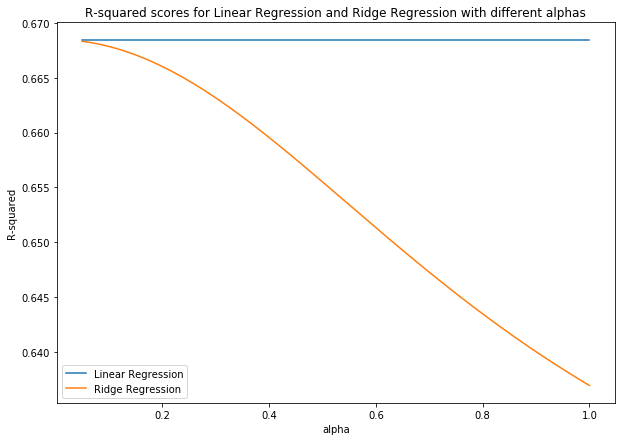

In [69]:
# Visualize R-squared scores for Linear Regression Model
# and Ridge Regression Model for different alpha values
plt.figure(figsize = (10,7))
plt.plot(alpha, LR_score, label = "Linear Regression")
plt.plot(alpha, RR_score, label = "Ridge Regression")
plt.title("R-squared scores for Linear Regression and Ridge Regression with different alphas")
plt.xlabel("alpha")
plt.ylabel("R-squared")
plt.legend()
plt.show()

<a id='p2'></a>
# Problem 2 [10pts]
We discussed how to create `Python` modules in lecture.  In this problem, you will create an very basic module and demonstrate some basic functionality.  The purpose of this exercise is to get you familiar with the essence of modules.

### Module
So far, we have only been writing short `Python` scripts. However, when your code base starts to get bigger, you might want to organize your function and class definitions. The idea behind modules is to split your function and class definitions into multiple, logical units.  When you want to use a function or class you simply import it from the module.  In essence, a module is a file containing `Python` definitions and statements.

### Part 1:  Create a module
Create a file called `MathCS207.py` inside your HW3 directory and include the following functions and names.  Please fill out the definition body.  `MathCS207.py` is now a module.

In [ ]:
def add(a,b):
    # your code here
    
def subtract(a,b):
    # your code here
    
def multiply(a,b):
    # your code here

def divide(a,b):
    # your code here


### Part 2:  Import a whole module and use it
Import the whole module you just created above and use the module's functions to perform addition, subtration, multiplication and division of the following numbers: 

<br><br>
$$a = 10$$
$$b = 2$$


In [76]:
import MathCS207

a = 10
b = 2
print(f"addition: {MathCS207.add(a,b)}")
print(f"subtract: {MathCS207.subtract(a,b)}")
print(f"multiply: {MathCS207.multiply(a,b)}")
print(f"division: {MathCS207.divide(a,b)}")

addition: 12
subtract: 8
multiply: 20
division: 5.0


### Part 3:  Import a single function from a module and use it
Import the "add" from the `MathCS207` module and use it to add the following numbers:

<br><br>
$$a = 10$$
$$b = 2$$

In [77]:
from MathCS207 import add
print(f"addition: {add(a,b)}")

addition: 12


### Part 4:  Import a module by creating an alias of it and then use the alias
Import the `MathCS207` module as `mathcs` and use it to add the following numbers:

<br><br>
$$a = 10$$
$$b = 2$$

In [78]:
import MathCS207 as mathcs

print(f"addition: {mathcs.add(a,b)}")

addition: 12


### Part 5:  List every function definition inside the module `MathCS207`
Import the `MathCS207` module and list every function that can be accessed through this module by using a `Python` built-in function.

In [79]:
import MathCS207

dir(MathCS207)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add',
 'divide',
 'multiply',
 'subtract']

---
<a id='p3'></a>
# Problem 3: Bank Account Revisited [50pts]

We are going to redo the bank account closure problem from homework 2, only this time developing a formal class for a Bank User and Bank Account to use in our closure (recall previously we just had a nonlocal variable amount that we changed).

### IMPORTANT
We will be grading this problem with a test suite. Put the `enum`, classes, and closure in a single file named `Bank.py`. It is very important that the class and method specifications we provide in the problem description are used (with the same capitalization), otherwise you will receive no credit.

### Some Preliminaries:
First define two types of bank accounts.  Use the code below to do this:

In [23]:
from enum import Enum
class AccountType(Enum):
    SAVINGS = 1
    CHECKING = 2

Now, just to orient you, let's expore this class a little bit.

In [28]:
AccountType.SAVINGS

<AccountType.SAVINGS: 1>

returns a `Python` representation of an enumeration.

You can compare these account types:

In [29]:
AccountType.SAVINGS == AccountType.SAVINGS

True

In [30]:
AccountType.SAVINGS == AccountType.CHECKING

False

Note that to get a string representation of an `Enum`, you can use:

In [31]:
AccountType.SAVINGS.name

'SAVINGS'

### Part 1: Create a BankAccount class with the following specification:

Constructor is `BankAccount(self, owner, accountType)` where `owner` is a string representing the name of the account owner and `accountType` is one of the AccountType `enums`

Methods `withdraw(self, amount)` and `deposit(self, amount)` to modify the account balance of the account.

Override methods `__str__` to write an informative string of the account owner and the type of account, and `__len__` to return the balance of the account

### Part 2:  Write a class BankUser with the following specification:

Constructor `BankUser(self, owner)` where `owner` is the name of the account.

Method `addAccount(self, accountType)` - to start, a user will have no accounts when the BankUser object is created. `addAccount` will add a new account to the user of the `accountType` specified. **Only one savings/checking account per user, return appropriate error otherwise.**

Methods `getBalance(self, accountType)`, `deposit(self, accountType, amount)`, and `withdraw(self, accountType, amount)` for a specific `AccountType`.

Override `__str__` to have an informative summary of user's accounts.

Write some simple tests to make sure this is working. Think of edge scenarios a user might try to do.

### Part 3:  ATM Closure

Finally, we are going to rewrite a closure to use our bank account. We will make use of the [input function](http://anh.cs.luc.edu/python/hands-on/3.1/handsonHtml/io.html) which takes user input to decide what actions to take.

Write a closure called `ATMSession(bankUser)` which takes in a `BankUser` object. It should return a method called `Interface` that, when called, would provide the following interface:

First screen for user will look like:


**Enter Option:**

**1)Exit**

**2)Create Account**

**3)Check Balance**

**4)Deposit**

**5)Withdraw**


Pressing 1 will exit, any other option will show the options:



**Enter Option:**

**1)Checking**

**2)Savings**


If a deposit or withdraw was chosen, then there must be a third screen:



**Enter Integer Amount, Cannot Be Negative:**

This is to keep the code relatively simple, if you'd like you can also curate the options depending on the `BankUser` object (for example, if the user has no accounts then only show the Create Account option), but this is up to you. In any case, you must handle any input from the user in a reasonable way that an actual bank would be okay with, and give the user a proper response to the action specified.

Upon finishing a transaction or viewing balance, it should go back to the original screen.

In [2]:
from bank import BankUser, ATMSession, AccountType

user1 = BankUser("Jaemin")
atm = ATMSession(user1)
atm()

Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
2
Enter Option:
1)Checking
2)Savings
2
SAVINGS Account has been created
Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
5
Enter Option:
1)Checking
2)Savings
2
Enter Integer Amount, Cannot Be Negative:200
ERROR: You have not enough balance
Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
5
Enter Option:
1)Checking
2)Savings
1
Enter Integer Amount, Cannot Be Negative:100
There is no CHECKING
Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
4
Enter Option:
1)Checking
2)Savings
1
Enter Integer Amount, Cannot Be Negative:100
There is no CHECKING
Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
3
Enter Option:
1)Checking
2)Savings
1
There is no CHECKING
Enter Option:
1)Exit
2)Create Account
3)Check Balance
4)Deposit
5)Withdraw
3
Enter Option:
1)Checking
2)Savings
2
Your SAVINGS account has 0
Enter Option:
1)Exit
2)

### Part 4:  Put everything in a module Bank.py

We will be grading this problem with a test suite. Put the enum, classes, and closure in a single file named Bank.py. It is very important that the class and method specifications we provided are used (with the same capitalization), otherwise you will receive no credit.

---